# Fish toxicity - regression analysis

In this notebook a regression analysis is applied to fish toxicity data . 
The dataset can be found here: https://archive.ics.uci.edu/ml/datasets/QSAR+fish+toxicity

Source of data (2019):
Davide Ballabio (davide.ballabio @ unimib.it), Matteo Cassotti, Viviana Consonni, Roberto Todeschini, Milano Chemometrics and QSAR Research Group 
(http://www.michem.unimib.it/), UniversitÃ  degli Studi Milano - Bicocca, Milano (Italy)
Relevant Papers: M. Cassotti, D. Ballabio, R. Todeschini, V. Consonni. A similarity-based QSAR model for predicting acute toxicity towards the fathead minnow (Pimephales promelas), SAR and QSAR in Environmental Research (2015), 26, 217-243; doi: 10.1080/1062936X.2015.1018938

6 molecular descriptors and 1 quantitative experimental response:
- 1) CIC0 (information indices)
- 2) SM1_Dz(Z) 
- 3) GATS1i (2D autocorrelations)
- 4) NdsCH (atom-type counts)
- 5) NdssC (atom-type counts)
- 6) MLOGP (molecular properties)
- 7) quantitative response, LC50 [-LOG(mol/L)]

## Loading the data

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load dataset
df=pd.read_csv('qsar_fish_toxicity.csv', header=None,sep=';')
df.columns=['X1','X2','X3','X4','X5','X6','Y']
df.head()

,X1,X2,X3,X4,X5,X6,Y
0,3.260,0.829,1.676,0,1,1.453,3.770
1,2.189,0.580,0.863,0,0,1.348,3.115
2,2.125,0.638,0.831,0,0,1.348,3.531
3,3.027,0.331,1.472,1,0,1.807,3.510
4,2.094,0.827,0.860,0,0,1.886,5.390


In [3]:
df.shape

(908, 7)

In [4]:
df.isnull().sum()

X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
Y     0
dtype: int64

## Data exploration

In [5]:
# Statistics of all variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
X1,908.0,2.898129,0.756088,0.667,2.34700,2.9340,3.40700,5.926
X2,908.0,0.628468,0.428459,0.000,0.22300,0.5700,0.89275,2.171
X3,908.0,1.293591,0.394303,0.396,0.95075,1.2405,1.56225,2.920
X4,908.0,0.229075,0.605335,0.000,0.00000,0.0000,0.00000,4.000
X5,908.0,0.485683,0.861279,0.000,0.00000,0.0000,1.00000,6.000
X6,908.0,2.109285,1.433181,-2.884,1.20900,2.1270,3.10500,6.515
Y,908.0,4.064431,1.455698,0.053,3.15175,3.9875,4.90750,9.612


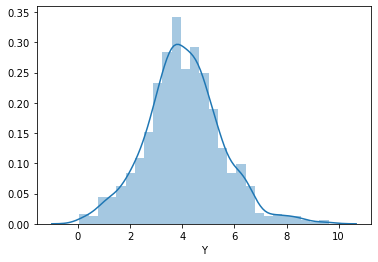

In [7]:
# The distribution of the Y quantitative response variable
sns.distplot(df['Y'])

<Figure size 432x288 with 0 Axes>

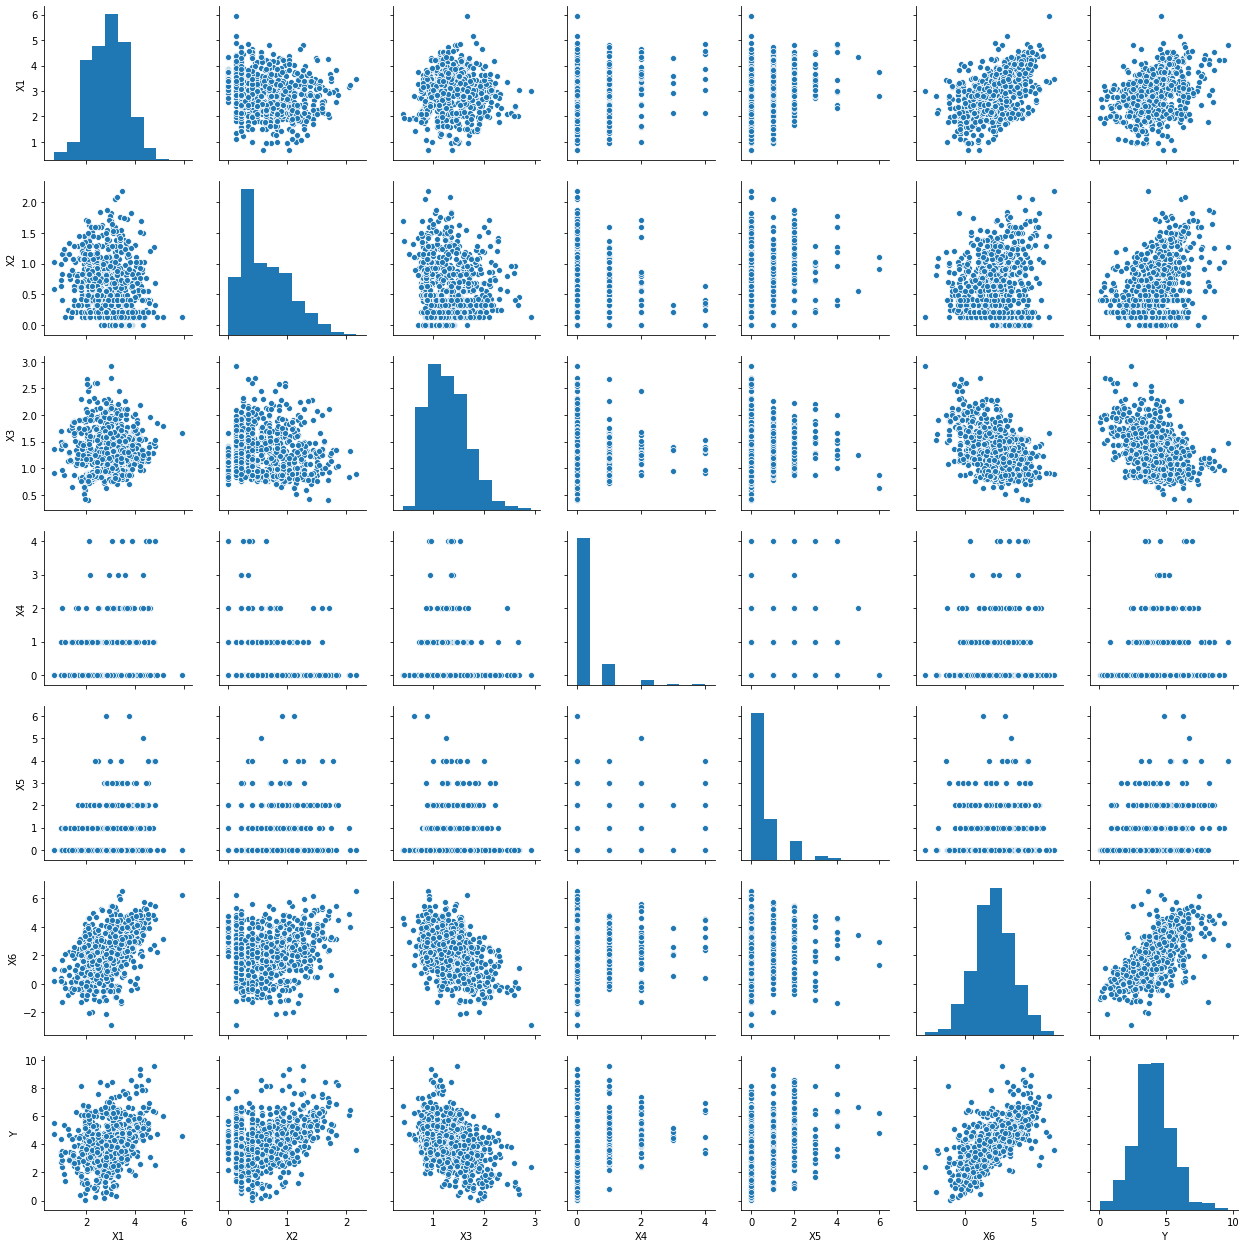

In [8]:
# Pairwise scatterplots between all variables: checking the outliers and linearity
from seaborn import pairplot
plt.tight_layout()
pairplot(df)

(7.0, 0.0)

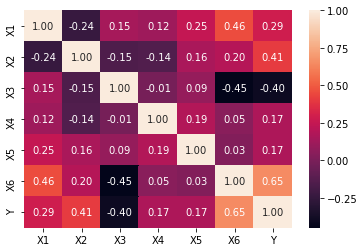

In [9]:
# Create a heatmap showing correlation between variables
corr = df.corr().round(2)
ax=sns.heatmap(corr,annot=True,fmt='.2f')
bottom, top=ax.get_ylim()
ax.set_ylim(bottom+0.5,top-0.5)

The regression variable X6 has quite high correlation with the target variable. 

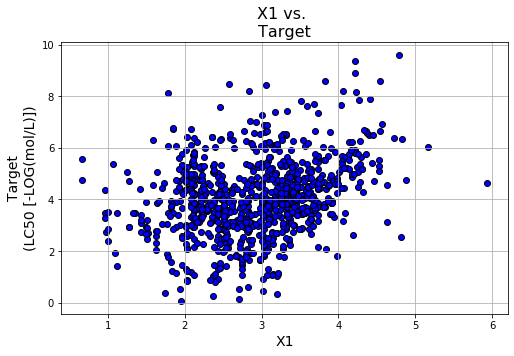

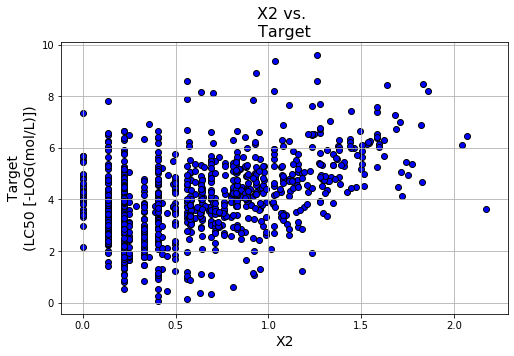

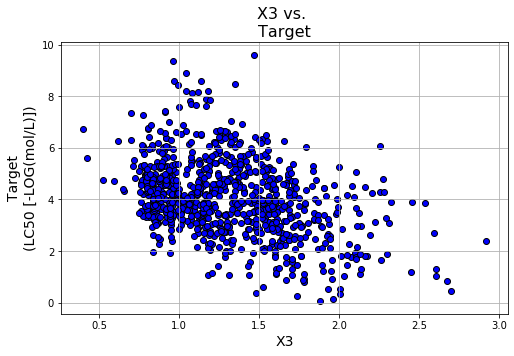

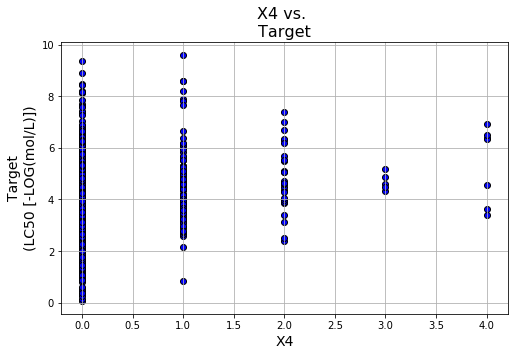

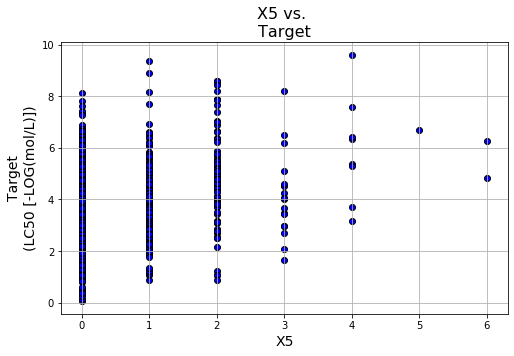

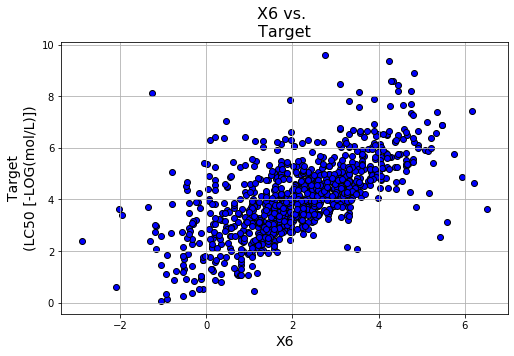

In [10]:
# Let's still check the linearity between regressors and predictor variable
for c in df.columns[:-1]:
    plt.figure(figsize=(8,5))
    plt.title("{} vs. \nTarget".format(c),fontsize=16)
    plt.scatter(x=df[c],y=df['Y'],color='blue',edgecolor='k')
    plt.grid(True)
    plt.xlabel(c,fontsize=14)
    plt.ylabel('Target\n(LC50 [-LOG(mol/L)])',fontsize=14)
    plt.show()

## Develop a regression model

### a) Linear regression model

Let's create a linear regression model first with all variables and then utilize recursive feature elimination, using crossvalidation, to select the best features.

In [12]:
import statsmodels.formula.api as sm   ## statsmodel contains summary statistics
from sklearn.linear_model import LinearRegression ## sklearn contains good model evalutions methods
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [13]:
data=df.astype(np.float64)

# Suppress warnings
warnings.filterwarnings(action="ignore", module="scipy",message="^internal gelsd")

# Create training and test sets
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(data[['X1','X2','X3','X4','X5','X6']],
                                                  data[['Y']], test_size=0.2, random_state = 42)
X_train=np.array(X_train_df)
y_train=np.array(y_train_df).ravel()
X_test=np.array(X_test_df)
y_test=np.array(y_test_df).ravel()
ols=LinearRegression()

# Recursive feature elimination
rfecv=RFECV(estimator=ols,step=1,scoring="neg_mean_squared_error",cv=5)
rfecv.fit(X_train,y_train)
rfecv.transform(X_train)

array([[5.926, 0.134, 1.671, 0.   , 0.   , 6.203],
       [2.405, 0.134, 0.843, 0.   , 0.   , 1.769],
       [3.052, 0.638, 0.903, 0.   , 0.   , 3.237],
       ...,
       [3.611, 0.331, 2.017, 0.   , 0.   , 1.393],
       [2.928, 1.131, 0.908, 0.   , 2.   , 3.508],
       [2.512, 0.134, 1.293, 0.   , 0.   , 0.846]])

Let's look at the number of features that should be kept in the model.

In [14]:
rfecv.n_features_

6

The result suggests that all the features should be included. Let's look at some predicted values.

In [15]:
# Create predictions with the training data, for the first 5 observations.
pred_lr_train=rfecv.predict(X_train)
print("Preds/train: ",pred_lr_train[:5].round(2))
print("Targets/train: ", y_train[:5].round(2))

Preds/train:  [5.87 3.31 4.74 4.06 3.67]
Targets/train:  [4.63 3.21 4.91 3.24 2.87]


Let's look at the root mean squared error, rmse, and r2-scores for this model, with the training data. Let's calculate also standard deviations for both.

In [16]:
rmse_lr_cv=np.sqrt(-cross_val_score(rfecv, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
rmse_lr=rmse_lr_cv.mean()
rmse_lr_std=rmse_lr_cv.std()
r2_lr_cv=cross_val_score(rfecv, X_train, y_train, scoring="r2", cv = 5)
r2_lr=r2_lr_cv.mean()
r2_lr_std=r2_lr_cv.std()
print('Linear regression results')
print('---------------------')
print('rmse for training set: ',rmse_lr)
print('rmse std for training set: ',rmse_lr_std)
print('r2 for training set set: ', r2_lr)
print('r2 std for training set set: ', r2_lr_std)

Linear regression results
---------------------
rmse for training set:  0.9381781819786745
rmse std for training set:  0.08819392475041042
r2 for training set set:  0.5565378624880511
r2 std for training set set:  0.10161171725956951


r2-score is still not very high. Let's try RandomForestRegressor.

### b) Random Forest Regressor

Let's try RandomForestRegressor. Let's find the parameters with the GridSearch.

In [17]:
# Define parameter values for gridsearch
param_grid=[
    {'n_estimators':[3,10,30],'max_features':[2,4,6]},
    {'bootstrap':[False],'n_estimators':[3,10,30],'max_features':[2,3,4]}
]

In [18]:
# Create the RandomForestRegressor
forest_reg=RandomForestRegressor(random_state=25)
grid_search=GridSearchCV(forest_reg,param_grid,cv=5,scoring='neg_mean_squared_error',iid=False)

In [19]:
# Perform grid search with the parameter set
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=25, verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6]}, {'bootstrap': [False], 'n_estimators': [3, 10, 30], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [20]:
# Look at the best parameter combination
grid_search.best_params_

{'max_features': 4, 'n_estimators': 30}

In [21]:
# Look at the root mean squared error for different parameter combinations
cvres=grid_search.cv_results_
for mean_score,params in zip(cvres["mean_test_score"],cvres["params"]):
    print(np.sqrt(-mean_score),params)

0.9957638618393897 {'max_features': 2, 'n_estimators': 3}
0.9162716711656937 {'max_features': 2, 'n_estimators': 10}
0.8672394587259702 {'max_features': 2, 'n_estimators': 30}
0.9905228867467427 {'max_features': 4, 'n_estimators': 3}
0.8940238846761024 {'max_features': 4, 'n_estimators': 10}
0.8651375059236702 {'max_features': 4, 'n_estimators': 30}
1.022599117793216 {'max_features': 6, 'n_estimators': 3}
0.9195101680461496 {'max_features': 6, 'n_estimators': 10}
0.8709904936260005 {'max_features': 6, 'n_estimators': 30}
0.9567944002294588 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
0.8897648595407709 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
0.8772287115848814 {'bootstrap': False, 'max_features': 2, 'n_estimators': 30}
0.9744015238931728 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
0.9141125136239061 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
0.8880901199517666 {'bootstrap': False, 'max_features': 3, 'n_estimators': 30}
0

In [22]:
#Let's look at the feature importances
attributes=list(X_train_df.columns)
feature_importances=grid_search.best_estimator_.feature_importances_
sorted(zip(feature_importances,attributes),reverse=True)

[(0.5032469992466955, 'X6'),
 (0.18822570613263592, 'X2'),
 (0.11920323558054889, 'X3'),
 (0.11912362275274341, 'X1'),
 (0.03714660319333954, 'X4'),
 (0.03305383309403676, 'X5')]

From the results it can be seen that X6 is the most important feature.

### c) Evaluating results: Linear regression vs. Fine-tuned Random Forest regressor

Let's compare the root mean squared error and R2-score between Linear regression model
and the fine-tuned Random Forest regressor.

In [27]:
# Let's take the random forest regressor with the best parameter combination
rf_model=grid_search.best_estimator_

In [28]:
rmse_rf_cv=np.sqrt(-cross_val_score(rf_model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
rmse_rf=rmse_rf_cv.mean()
rmse_rf_std=rmse_rf_cv.std()
r2_rf_cv=cross_val_score(rf_model, X_train, y_train, scoring="r2", cv = 5)
r2_rf=r2_rf_cv.mean()
r2_rf_std=r2_rf_cv.std()
print('Random forest results (training set)')
print('-------------------------------------')
print('rmse for training set: ',rmse_rf)
print('rmse std for training set: ',rmse_rf_std)
print('r2 for training set set: ', r2_rf)
print('r2 std for training set set: ', r2_rf_std)
print(' ')
print('Linear regression results (training set)')
print('---------------------------------------')
print('rmse for training set: ',rmse_lr)
print('rmse std for training set: ',rmse_lr_std)
print('r2 for training set set: ', r2_lr)
print('r2 std for training set set: ', r2_lr_std)

Random forest results (training set)
-------------------------------------
rmse for training set:  0.863360246541142
rmse std for training set:  0.055425525241058246
r2 for training set set:  0.6228149310288046
r2 std for training set set:  0.08101949467664328
 
Linear regression results (training set)
---------------------------------------
rmse for training set:  0.9381781819786745
rmse std for training set:  0.08819392475041042
r2 for training set set:  0.5565378624880511
r2 std for training set set:  0.10161171725956951


The r2 improved somewhat , but not very much. Let's create a Random Forest regressor so that only the most important features are included: X6,X2,X3,X1.

### d) Random Forest regressor - new model with only the best four features

In [29]:
# Create training and test sets
X_train_df_4, X_test_df_4, y_train_df_4, y_test_df_4 = train_test_split(data[['X1','X2','X3','X6']],
                                                  data[['Y']], test_size=0.2, random_state = 42)
X_train4=np.array(X_train_df_4)
y_train4=np.array(y_train_df_4).ravel()
X_test4=np.array(X_test_df_4)
y_test4=np.array(y_test_df_4).ravel()

In [30]:
# Define parameter values for gridsearch
param_grid4=[
    {'n_estimators':[3,10,30],'max_features':[1,2,3,4]},
]

In [31]:
# Create the RandomForestRegressor for the reduced number of regressors
forest_reg4=RandomForestRegressor(random_state=25)
grid_search4=GridSearchCV(forest_reg4,param_grid4,cv=5,scoring='neg_mean_squared_error',iid=False)

In [32]:
# Perform the grid search
grid_search4.fit(X_train4,y_train4)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=25, verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [1, 2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [33]:
# Look at the best parameter combination
grid_search4.best_params_

{'max_features': 2, 'n_estimators': 30}

In [34]:
cvres4=grid_search4.cv_results_
for mean_score,params in zip(cvres4["mean_test_score"],cvres4["params"]):
    print(np.sqrt(-mean_score),params)

1.0555894123231344 {'max_features': 1, 'n_estimators': 3}
0.9424866616350607 {'max_features': 1, 'n_estimators': 10}
0.9049529763046312 {'max_features': 1, 'n_estimators': 30}
1.0209873657782762 {'max_features': 2, 'n_estimators': 3}
0.9380621305869208 {'max_features': 2, 'n_estimators': 10}
0.9031300247678515 {'max_features': 2, 'n_estimators': 30}
1.031031765885862 {'max_features': 3, 'n_estimators': 3}
0.9433041677340697 {'max_features': 3, 'n_estimators': 10}
0.9137413816433512 {'max_features': 3, 'n_estimators': 30}
1.0699896381449732 {'max_features': 4, 'n_estimators': 3}
0.9630587244492866 {'max_features': 4, 'n_estimators': 10}
0.9153018990611694 {'max_features': 4, 'n_estimators': 30}


In [35]:
#Let's look at the feature importances
attributes4=['X1','X2','X3','X6']
feature_importances4=grid_search4.best_estimator_.feature_importances_
sorted(zip(feature_importances4,attributes4),reverse=True)

[(0.4356039525388261, 'X6'),
 (0.24819835288071612, 'X2'),
 (0.15946079294845308, 'X3'),
 (0.1567369016320046, 'X1')]

### e) Evaluating results: Linear regression vs. Fine-tuned Random Forest regressor with 4 regressors

Let's compare the root mean squared error and R2-score between Linear regression model
and the fine-tuned Random Forest regressor with 4 regressors.

In [36]:
# Let's take the random forest model with the best parameter combination
rf_model4=grid_search4.best_estimator_

In [37]:
rmse_rf4_cv=np.sqrt(-cross_val_score(rf_model4, X_train4, y_train4, scoring="neg_mean_squared_error", cv = 5))
rmse_rf4=rmse_rf4_cv.mean()
rmse_rf4_std=rmse_rf4_cv.std()
r2_rf4_cv=cross_val_score(rf_model4, X_train4, y_train4, scoring="r2", cv = 5)
r2_rf4=r2_rf4_cv.mean()
r2_rf4_std=r2_rf4_cv.std()
print('Random forest results/ 4 regressors(training set)')
print('--------------------------------------------')
print('rmse for training set: ',rmse_rf4)
print('rmse std for training set: ',rmse_rf4_std)
print('r2 for training set set: ', r2_rf4)
print('r2 std for training set set: ', r2_rf4_std)
print(' ')
print('Random forest results/ 6 regressors (training set)')
print('------------------------------------------')
print('rmse for training set: ',rmse_rf)
print('rmse std for training set: ',rmse_rf_std)
print('r2 for training set set: ', r2_rf)
print('r2 std for training set set: ', r2_rf_std)
print(' ')
print('Linear regression results (training set)')
print('---------------------------------------')
print('rmse for training set: ',rmse_lr)
print('rmse std for training set: ',rmse_lr_std)
print('r2 for training set set: ', r2_lr)
print('r2 std for training set set: ', r2_lr_std)

Random forest results/ 4 regressors(training set)
--------------------------------------------
rmse for training set:  0.899986080962389
rmse std for training set:  0.07529206937746157
r2 for training set set:  0.5869225182082485
r2 std for training set set:  0.105409847226956
 
Random forest results/ 6 regressors (training set)
------------------------------------------
rmse for training set:  0.863360246541142
rmse std for training set:  0.055425525241058246
r2 for training set set:  0.6228149310288046
r2 std for training set set:  0.08101949467664328
 
Linear regression results (training set)
---------------------------------------
rmse for training set:  0.9381781819786745
rmse std for training set:  0.08819392475041042
r2 for training set set:  0.5565378624880511
r2 std for training set set:  0.10161171725956951


Using only four regressors did not really improve the model. rmse increased and r2-score decreased.

Let's go back in analysing the linear regression, and possibly ridge regularization for it.

## Diagnostics for the linear regression model

Next, the linear regression model will be analysed with regards to its quality.

### a) Linear regression model summary

Let's analyse the regression model with the help of the summary. 
There is not this kind of summary available in scikit-learn, and thus statsmodel is used instead.

In this model all the regression variables X1-X6 are included.

In [38]:
data_train=pd.concat([X_train_df,y_train_df],axis=1)
#Create a regression formula as a string
formula = data_train.columns[-1] +' ~ '+'+'.join(data_train.columns[:-1])
formula

'Y ~ X1+X2+X3+X4+X5+X6'

In [39]:
#Create a regression model for the training data with the statsmodel
regmodel=sm.ols(formula=formula, data=data_train)
fitted = regmodel.fit()

In [40]:
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     165.4
Date:                Mon, 21 Oct 2019   Prob (F-statistic):          8.92e-132
Time:                        05:44:47   Log-Likelihood:                -974.31
No. Observations:                 726   AIC:                             1963.
Df Residuals:                     719   BIC:                             1995.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0644      0.202     10.242      0.0

### b) P-values of regression coefficients

With the help of P-values, it is defined which regression coefficients are statistically significant.

In [41]:
def significant(b):
    if b<0.05:
        return 'Yes'
    else:
        return 'No'

In [42]:
# Create result dataframe: p-values and statistical significance of the features
df_result=pd.DataFrame()
df_result['P-values']=fitted.pvalues[1:]
df_result['Features']=data_train.columns[:-1]
df_result.set_index('Features',inplace=True)
df_result['Statistically significant']= df_result['P-values'].apply(significant)
df_result

,P-values,Statistically significant
Features,,
X1,2.992852e-10,Yes
X2,7.367194e-38,Yes
X3,1.777649e-11,Yes
X4,6.015589e-09,Yes
X5,1.970985e-01,No
X6,8.620837e-23,Yes


All the regression variables in the model are statistically significant, except X5.
X5 was the least important feature also in the feature important list of the Random Forest regressor.

Let's create a modified linear regression model so that X5 regressor is left out, to see if this improves the results.

### c) Modified Linear regression model - leaving out X5 regressor

In [43]:
data_train5=data_train[['X1','X2','X3','X4','X6','Y']]
formula5 = data_train5.columns[-1] +' ~ '+'+'.join(data_train5.columns[:-1])
formula5

'Y ~ X1+X2+X3+X4+X6'

In [44]:
#Create a regression model for the training data with the statsmodel and look at the summary.
regmodel5=sm.ols(formula=formula5, data=data_train5)
fitted5 = regmodel5.fit()
print(fitted5.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     198.0
Date:                Mon, 21 Oct 2019   Prob (F-statistic):          1.38e-132
Time:                        05:50:35   Log-Likelihood:                -975.15
No. Observations:                 726   AIC:                             1962.
Df Residuals:                     720   BIC:                             1990.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0082      0.197     10.199      0.0

R2-score did not change very much , it is still R2=0.58. 

### d) P-values of regression coefficients for the modified linear model

Let's look at the significance of the regression coefficients again with the help of P-values.

In [45]:
# Create result dataframe: p-values and statistical significance of the features
df_result5=pd.DataFrame()
df_result5['P-values']=fitted5.pvalues[1:]
df_result5['Features']=data_train5.columns[:-1]
df_result5.set_index('Features',inplace=True)
df_result5['Statistically significant']= df_result5['P-values'].apply(significant)
df_result5

,P-values,Statistically significant
Features,,
X1,1.806559e-12,Yes
X2,5.714342e-43,Yes
X3,1.275230e-11,Yes
X4,4.597377e-10,Yes
X6,1.699574e-22,Yes


Now all the regression variables in the model are statistically significant.

### e) Variance inflation factor

To check whether regression variables are causing the multicollinearity, let's calculate 
variance inflation factor for each variable.

In [46]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [47]:
for i in range(len(data_train5.columns[:-1])):
    v=vif(np.matrix(data_train5[:-1]),i)
    print("Variance inflation factor for {}: {}".format(data_train5.columns[i],round(v,2)))

Variance inflation factor for X1: 29.79
Variance inflation factor for X2: 5.0
Variance inflation factor for X3: 14.41
Variance inflation factor for X4: 1.26
Variance inflation factor for X6: 8.1


There are high variance inflation factors for regressors X1 and X3. Usually Vif>10 is considered to be a too high value.

Let's analyse the residuals vs. predicting variables next.

### f) Residuals vs. predicting variables plots

Let's create residual plots vs regression variables, to analyse whether errors are independent from each other.

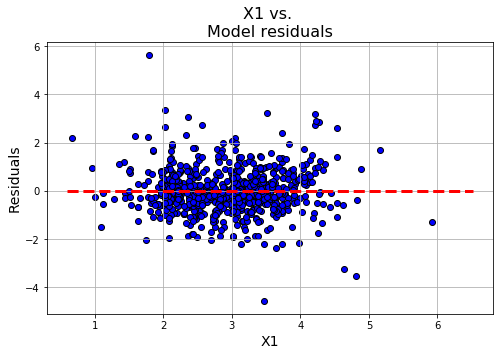

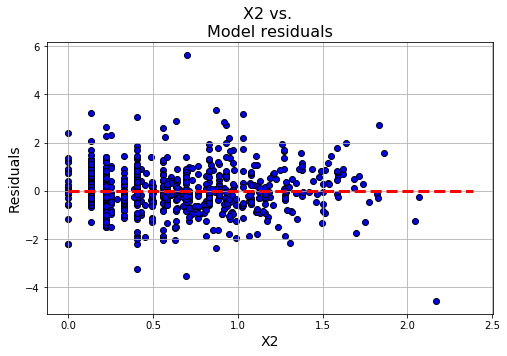

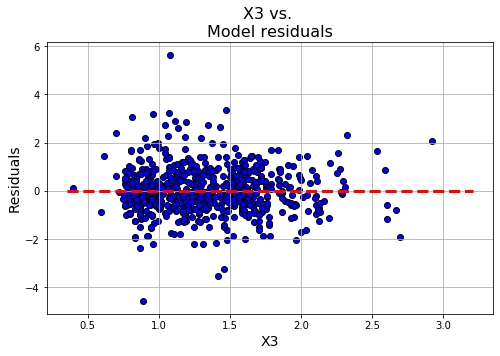

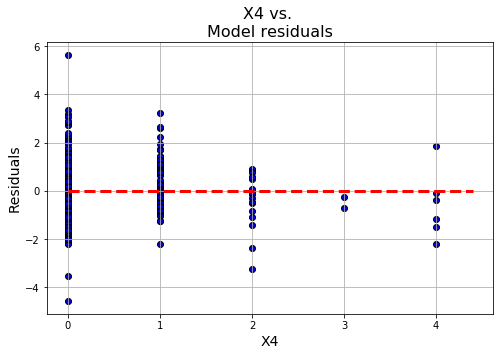

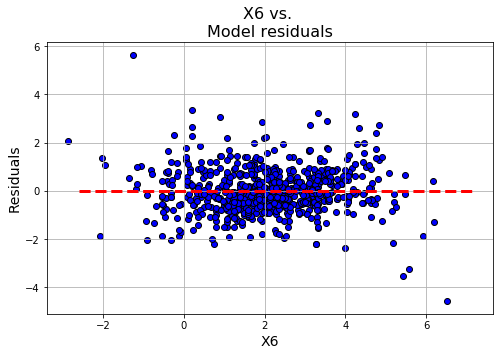

In [48]:
regressors=['X1','X2','X3','X4','X6']
for c in regressors:
    plt.figure(figsize=(8,5))
    plt.title("{} vs. \nModel residuals".format(c),fontsize=16)
    plt.scatter(x=data_train5[c],y=fitted5.resid,color='blue',edgecolor='k')
    plt.grid(True)
    xmin=min(data_train5[c])
    xmax = max(data_train5[c])
    plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
    plt.xlabel(c,fontsize=14)
    plt.ylabel('Residuals',fontsize=14)
    plt.show()

For all the regressors, the residuals are quite uniformly randomly occurring around the 0 axis. 

### g) Cook's distance to analyse outliers

Let's calculate Cook's distance to analyse outliers.

In [49]:
from statsmodels.stats.outliers_influence import OLSInfluence as influence
inf=influence(fitted5)

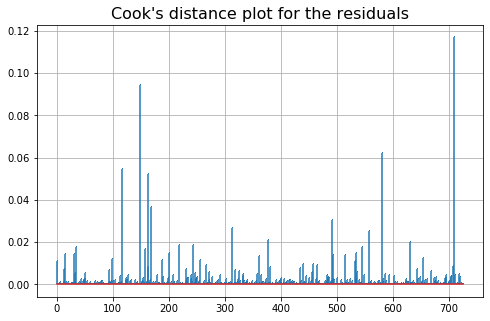

In [50]:
(c, p) = inf.cooks_distance
plt.figure(figsize=(8,5))
plt.title("Cook's distance plot for the residuals",fontsize=16)
plt.stem(np.arange(len(c)), c, markerfmt=",",use_line_collection=True)
plt.grid(True)
plt.show()

There seems to exist some possible outliers.

### f) Fitted values vs. residuals

Let's plot residuals vs. fitted values, in order to see if errors have constant variance.

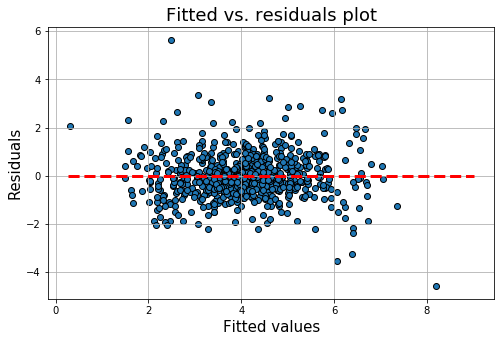

In [51]:
plt.figure(figsize=(8,5))
p=plt.scatter(x=fitted5.fittedvalues,y=fitted5.resid,edgecolor='k')
xmin=min(fitted5.fittedvalues)
xmax = max(fitted5.fittedvalues)
plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
plt.xlabel("Fitted values",fontsize=15)
plt.ylabel("Residuals",fontsize=15)
plt.title("Fitted vs. residuals plot",fontsize=18)
plt.grid(True)
plt.show()

There are some outliers, but generally constant variance assumption is held.

### g) Checking the normality assumption of the residuals

Let's plot the histogram of residuals to see whether the normality of residuals assumption holds.

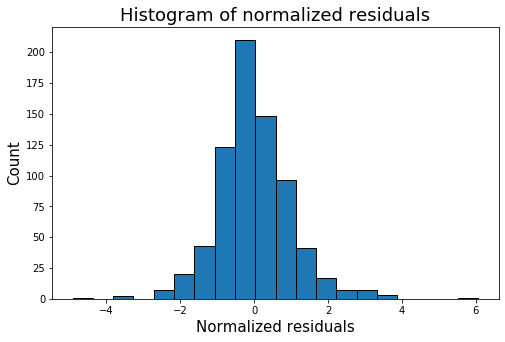

In [52]:
plt.figure(figsize=(8,5))
plt.hist(fitted5.resid_pearson,bins=20,edgecolor='k')
plt.ylabel('Count',fontsize=15)
plt.xlabel('Normalized residuals',fontsize=15)
plt.title("Histogram of normalized residuals",fontsize=18)
plt.show()

Let's also create a Q-Q plot of normalized residuals.

In [53]:
from statsmodels.graphics.gofplots import qqplot

<Figure size 576x360 with 0 Axes>

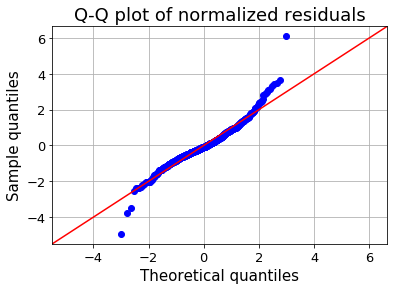

In [54]:
plt.figure(figsize=(8,5))
fig=qqplot(fitted5.resid_pearson,line='45',fit='True')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Theoretical quantiles",fontsize=15)
plt.ylabel("Sample quantiles",fontsize=15)
plt.title("Q-Q plot of normalized residuals",fontsize=18)
plt.grid(True)
plt.show()

From the histogram and Q-Q plot of normalized residuals, it can be concluded that the normality assumption holds.

Let's still perform the normality (Shapiro-Wilk) test of the residuals.

In [55]:
from scipy.stats import shapiro
_,p=shapiro(fitted.resid)
p

7.032377609926532e-13

In [56]:
if p<0.01:
    print("The residuals seem to come from Gaussian process")
else:
    print("The normality assumption may not hold")

The residuals seem to come from Gaussian process


## Ridge regression model

Based on the diagnostics of the linear models, one of the main problems, reducing the quality of the model, is the multicollinearity between the regressors.
Due to that the variance inflation factors were very high for some of the regressors.

To mitigate the multicollinearity, let's create a linear regression model with regularisation, in specific, Ridge regression model.
Let's use again the other regressors, except X5, since X5 was not statistically significant according to its Pvalue. 

In [57]:
from sklearn.linear_model import Ridge, RidgeCV

In [58]:
# Create training and test sets so that X5 is dropped out
X_train_df_5, X_test_df_5, y_train_df_5, y_test_df_5 = train_test_split(data[['X1','X2','X3','X4','X6']],
                                                  data[['Y']], test_size=0.2, random_state = 42)
X_train5=np.array(X_train_df_5)
y_train5=np.array(y_train_df_5).ravel()
X_test5=np.array(X_test_df_5)
y_test5=np.array(y_test_df_5).ravel()

Plot the rmse as a function of alpha, to find the best value for alpha.

Text(0, 0.5, 'rmse')

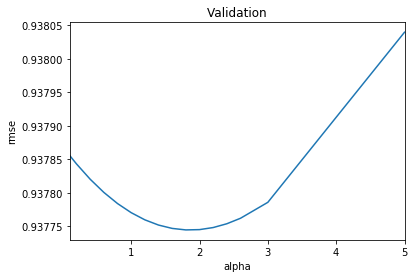

In [59]:
alphas = [0.1, 0.2, 0.4,0.6,0.8,1,1.2,1.4,1.6,1.8,2,2.2,2.4,2.6, 3, 5]
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train5, y_train5, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)
cv_ridge_rmse = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]
cv_ridge_rmse = pd.Series(cv_ridge_rmse, index = alphas)
cv_ridge_rmse.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [60]:
cv_ridge_rmse.idxmin(), cv_ridge_rmse.min()

(1.8, 0.9377445839804877)

Let's create the ridge model with the alpha=1.8.

In [61]:
ridge_reg=Ridge(alpha=1.8)
fitted_ridge=ridge_reg.fit(X_train5,y_train5)

Then compare the rmse and r2-score with those of the other models.

In [62]:
rmse_ridge_cv=np.sqrt(-cross_val_score(ridge_reg, X_train5, y_train5, scoring="neg_mean_squared_error", cv = 5))
rmse_ridge=rmse_ridge_cv.mean()
rmse_ridge_std=rmse_ridge_cv.std()
r2_ridge_cv=cross_val_score(ridge_reg, X_train5, y_train5, scoring="r2", cv = 5)
r2_ridge=r2_ridge_cv.mean()
r2_ridge_std=r2_ridge_cv.std()
print('Ridge regression results/ 5 regressors (training set)')
print('------------------------------------------')
print('rmse for training set: ',rmse_ridge)
print('rmse std for training set: ',rmse_ridge_std)
print('r2 for training set set: ', r2_ridge)
print('r2 std for training set set: ', r2_ridge_std)
print(' ')
print('Random forest results/ 6 regressors (training set)')
print('------------------------------------------')
print('rmse for training set: ',rmse_rf)
print('rmse std for training set: ',rmse_rf_std)
print('r2 for training set set: ', r2_rf)
print('r2 std for training set set: ', r2_rf_std)
print(' ')
print('Linear regression results/ 6 regressors (training set)')
print('---------------------------------------')
print('rmse for training set: ',rmse_lr)
print('rmse std for training set: ',rmse_lr_std)
print('r2 for training set set: ', r2_lr)
print('r2 std for training set set: ', r2_lr_std)

Ridge regression results/ 5 regressors (training set)
------------------------------------------
rmse for training set:  0.9377445839804877
rmse std for training set:  0.08737375227823074
r2 for training set set:  0.5570939489169817
r2 std for training set set:  0.10051136204827402
 
Random forest results/ 6 regressors (training set)
------------------------------------------
rmse for training set:  0.863360246541142
rmse std for training set:  0.055425525241058246
r2 for training set set:  0.6228149310288046
r2 std for training set set:  0.08101949467664328
 
Linear regression results/ 6 regressors (training set)
---------------------------------------
rmse for training set:  0.9381781819786745
rmse std for training set:  0.08819392475041042
r2 for training set set:  0.5565378624880511
r2 std for training set set:  0.10161171725956951


The results were not very much improved for the ridge regression compared to random forest or linear regression.
rmse and r2 remained quite the same level as with linear regression , at least for the training set.

Thus the best model is Random Forest regressor. Let's evaluate that with the test set.

## Evaluation with the test set - Random Forest regression

Let's evaluate mmse and r2-score for the Random Forest regression model, containing all 6 regressors, with the test set.

In [63]:
predicted_rf_train=rf_model.predict(X_train)
predicted_rf_test=rf_model.predict(X_test)

In [64]:
print('rmse for training set: ',rmse_rf)
print('rmse for test set: ',mean_squared_error(y_test,predicted_rf_test))
print('r2 for training set set: ', r2_rf)
print('r2 for test set: ',r2_score(y_test,predicted_rf_test))

rmse for training set:  0.863360246541142
rmse for test set:  1.050490315991893
r2 for training set set:  0.6228149310288046
r2 for test set:  0.5658190752430443


Let's create a scatter plot between predicted and true values, both for training and test set.

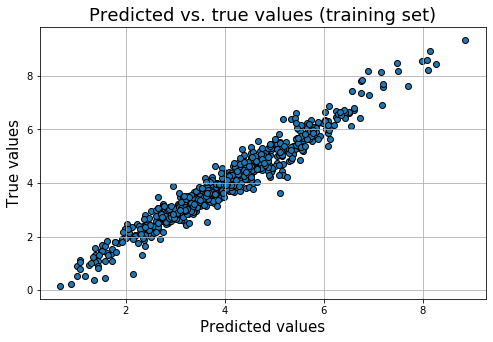

In [66]:
plt.figure(figsize=(8,5))
p=plt.scatter(x=predicted_rf_train,y=y_train,edgecolor='k')
xmin=min(predicted_rf_train)
xmax = max(predicted_rf_train)
plt.xlabel("Predicted values",fontsize=15)
plt.ylabel("True values",fontsize=15)
plt.title("Predicted vs. true values (training set)",fontsize=18)
plt.grid(True)
plt.show()

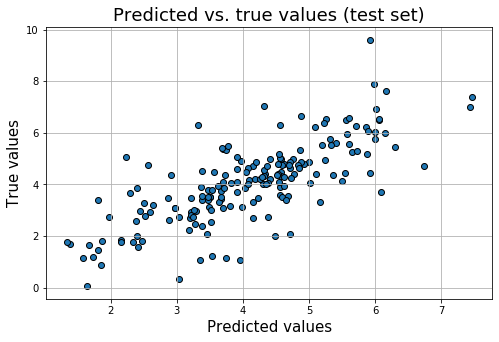

In [68]:
plt.figure(figsize=(8,5))
p=plt.scatter(x=predicted_rf_test,y=y_test,edgecolor='k')
xmin=min(predicted_rf_test)
xmax = max(predicted_rf_test)
plt.xlabel("Predicted values",fontsize=15)
plt.ylabel("True values",fontsize=15)
plt.title("Predicted vs. true values (test set)",fontsize=18)
plt.grid(True)
plt.show()

### Conclusions

In this analysis linear regression, ridge regression and Random forest regression were used for creating a model for predicting fish toxicity.

There was no big difference whether to use linear regression model without regularization or the ridge regression model. 
Using regularization did not really improve R2 score or rmse value that much.

Random Forest regressor gave the best results for the R2 score and rmse, and thus that was selected.

The model is not very good though, since the R2 score was only 0.56 for the test set. 

One focus area in this exercise was to practice different diagnostic methods for linear regression.